In [1]:
!git clone https://github.com/niazwazir/WAZIR_CORONA.git

Cloning into 'WAZIR_CORONA'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 801 (delta 0), reused 0 (delta 0), pack-reused 739
Receiving objects: 100% (801/801), 342.60 MiB | 15.38 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Checking out files: 100% (707/707), done.


In [2]:
cd WAZIR_CORONA/

/content/WAZIR_CORONA


In [3]:
cd DATASET/

/content/WAZIR_CORONA/DATASET


In [5]:
!pip install catboost

     |████████████████████████████████| 66.1MB 46kB/s 


In [6]:
# Importing the Libraries
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNet,VGG16,VGG19, DenseNet121,ResNet152,InceptionResNetV2,InceptionV3,VGG19,ResNet50,Xception
from keras.applications.mobilenet import preprocess_input
# from keras.applications.resnet50 import preprocess_input

from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,roc_curve,auc
# from mlxtend.evaluate import confusion_matrix
# from mlxtend.plotting import plot_confusion_matrix

import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,KFold
import tensorflow as tf

In [7]:
# Loading Training Images
normal_images=os.listdir(os.path.join('TRAINING DATASET','COVID_NEGATIVE'))
covid_images=os.listdir(os.path.join('TRAINING DATASET','COVID_POSITIVE'))

In [8]:
# Empty DataFrame
normal_image_df=pd.DataFrame()
covid_image_df=pd.DataFrame()

In [9]:
normal_image_df['ID']=normal_images
normal_image_df['label']='normal'

In [10]:
covid_image_df['ID']=covid_images
covid_image_df['label']='covid'

In [11]:
covid_image_df

,ID,label
0,COVIDPOSITIVE204.jpg,covid
1,COVIDPOSITIVE76.jpg,covid
2,COVIDPOSITIVE15.jpg,covid
3,COVIDPOSITIVE17.jpg,covid
4,COVIDPOSITIVE222.jpg,covid
...,...,...
148,COVIDPOSITIVE6.jpg,covid
149,COVIDPOSITIVE92.jpg,covid
150,COVIDPOSITIVE45.jpg,covid
151,COVIDPOSITIVE71.jpg,covid


In [12]:
train_df=pd.concat([normal_image_df,covid_image_df],ignore_index=True)

In [13]:
train_df.head(10)

,ID,label
0,NORMAL123.jpg,normal
1,NORMAL140.jpg,normal
2,NORMAL9.jpg,normal
3,NORMAL125.jpg,normal
4,NORMAL111.jpg,normal
5,NORMAL54.jpg,normal
6,NORMAL37.jpg,normal
7,NORMAL135.jpg,normal
8,NORMAL107.jpg,normal
9,NORMAL0.jpg,normal


In [14]:
len(train_df)

353

In [15]:
# Loading Train Images
train_images = []
train_labels=[]
for img_name,label in zip(train_df.ID,train_df.label):
  if label=='normal':
      img = cv2.imread(os.path.join('TRAINING DATASET/COVID_NEGATIVE',img_name))
      img=cv2.resize(img,(224,224))
      if img is not None:
          train_images.append(img)
          train_labels.append('normal')
  else:
      img=cv2.imread(os.path.join('TRAINING DATASET/COVID_POSITIVE',img_name))
      img=cv2.resize(img,(224,224))
      if img is not None:
        train_images.append(img)
        train_labels.append('covid')


In [16]:
len(train_images)

353

In [17]:
# Loading Testing Images
test_normal_images=os.listdir(os.path.join('TEST DATASET/COVID_NEGATIVE'))
test_covid_images=os.listdir(os.path.join('TEST DATASET/COVID_POSITIVE'))

In [18]:
len(test_covid_images)

203

In [19]:
# Empty DataFrame
test_normal_image_df=pd.DataFrame()
test_covid_image_df=pd.DataFrame()

In [20]:
test_normal_image_df['ID']=test_normal_images
test_normal_image_df['label']='normal'

In [21]:
test_covid_image_df['ID']=test_covid_images
test_covid_image_df['label']='covid'

In [22]:
test_df=pd.concat([test_normal_image_df,test_covid_image_df],ignore_index=True)

In [23]:
len(test_df)

353

In [24]:
len(list(set(test_normal_images)))

150

In [25]:
# Loading Testing Images
test_images = []
test_labels=[]
for img_name,label in zip(test_df.ID,test_df.label):
  if label=='normal':
        img = cv2.imread(os.path.join('TEST DATASET/COVID_NEGATIVE',img_name))
        img=cv2.resize(img,(224,224))
        if img is not None:
            test_images.append(img)
            test_labels.append('normal')
  else:
      img=cv2.imread(os.path.join('TEST DATASET/COVID_POSITIVE',img_name))
      img=cv2.resize(img,(224,224))
      if img is not None:
        test_images.append(img)
        test_labels.append('covid')


In [26]:
train_images=np.array(train_images)
test_images=np.array(test_images)

In [27]:
# # Normalizing Train and Test Images
# train_images=train_images/255.
# test_images=test_images/255.

In [28]:
len(test_images)

353

In [29]:
# Feature Extraction for train
#model = MobileNet(weights='imagenet', include_top=False)
#model = VGG16(weights='imagenet', include_top=False)
#model = DenseNet121(weights='imagenet', include_top=False)
#model = ResNet152(weights='imagenet', include_top=False)
#model = InceptionResNetV2(weights='imagenet', include_top=False)
#model = InceptionV3(weights='imagenet', include_top=False)
#model = VGG19(weights='imagenet', include_top=False)
model = Xception(weights='imagenet', include_top=False)

model_feature_list = []

for img in train_images:  
    img_data = np.expand_dims(img, axis=0)
    img_data = preprocess_input(img_data)

    model_feature = model.predict(img_data)
    model_feature_np = np.array(model_feature)
    model_feature_list.append(model_feature_np.flatten())

train_x = np.array(model_feature_list)

83689472/83683744 [==============================] - 1s 0us/step


In [30]:
# Feature Extraction for test
#model = MobileNet(weights='imagenet', include_top=False)
#model = VGG16(weights='imagenet', include_top=False)
#model = DenseNet121(weights='imagenet', include_top=False)
#model = ResNet152(weights='imagenet', include_top=False)
#model = InceptionResNetV2(weights='imagenet', include_top=False)
#model = InceptionV3(weights='imagenet', include_top=False)
#model = VGG19(weights='imagenet', include_top=False)
model = Xception(weights='imagenet', include_top=False)
model_feature_list = []

for img in test_images:  
    img_data = np.expand_dims(img, axis=0)
    img_data = preprocess_input(img_data)

    model_feature = model.predict(img_data)
    model_feature_np = np.array(model_feature)
    model_feature_list.append(model_feature_np.flatten())

test_x = np.array(model_feature_list)

In [31]:
# Label Encoding
train_y=pd.Series(train_labels)
label_encode={'normal':0,'covid':1}
train_y=train_y.replace(label_encode)
test_y=pd.Series(test_labels)
test_y=test_y.replace(label_encode)
train_y=train_y.astype('category')
test_y=test_y.astype('category')

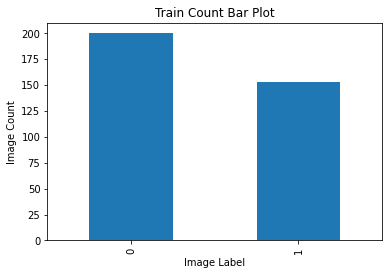

In [32]:
# Count Bar Plot Train
train_y.value_counts().plot(kind='bar')
plt.plot()
plt.title('Train Count Bar Plot')
plt.xlabel('Image Label')
plt.ylabel('Image Count')
plt.show()


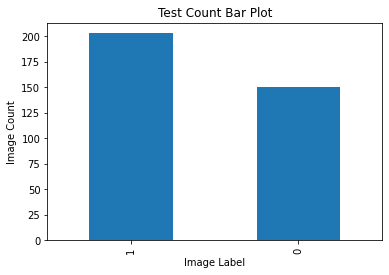

In [33]:
# Count Bar Plot on Test Data
test_y.value_counts().plot(kind='bar')
plt.plot()
plt.title('Test Count Bar Plot')
plt.xlabel('Image Label')
plt.ylabel('Image Count')
plt.show()

In [34]:
test_y.dtype

CategoricalDtype(categories=[0, 1], ordered=False)

In [35]:
# Fitting the Classifier
# classifier=SVC(kernel='rbf',C=0.5)
# classifier.fit(train_x,train_y)


# classifier=RandomForestClassifier(n_estimators=400,max_depth=7)
# classifier.fit(train_x,train_y)

# model = CatBoostClassifier(iterations=1500, learning_rate=0.01, l2_leaf_reg=3.5, depth=8, rsm=0.98, loss_function= 'Logloss', eval_metric='Accuracy',use_best_model=True,random_seed=42,gpu_ram_part=0.3,gpu_cat_features_storage='CpuPinnedMemory')
# model.fit(train_x,train_y,eval_set=(test_x,test_y))
# classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=42,n_estimators=1000)
# classifier.fit(train_x,train_y)
# classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
# classifier= LGBMClassifier(boosting_type='gbdt',objective='binary',metric='accuracy')
classifier=KNeighborsClassifier(n_neighbors=120,p=2)
classifier.fit(train_x,train_y)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=120, p=2,
                     weights='uniform')

In [36]:
# # n_neighbors selection
# neighbors = list(range(1,20))
# train_results = []
# test_results = []
# for n in neighbors:
#    model = KNeighborsClassifier(n_neighbors=n)
#    model.fit(train_x, train_y)
#    train_pred = model.predict(train_x)
#    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y, train_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    train_results.append(roc_auc)
#    y_pred = model.predict(test_x)
#    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, y_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    test_results.append(roc_auc)
# from matplotlib.legend_handler import HandlerLine2D
# line1, = plt.plot(neighbors, train_results, 'b', label='Train AUC')
# line2, = plt.plot(neighbors, test_results, 'r', label='Test AUC')
# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel('AUC score')
# plt.xlabel('n_neighbors')
# plt.show()

In [37]:
neighbors = list(range(1,200))

In [38]:
neighbors

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [39]:
# # Hyperparameter Tuning
# param_grid = {'n_neighbors':[80,90,120,200]}
# grid=GridSearchCV(estimator=KNeighborsClassifier(),cv=5,param_grid=param_grid)
# grid.fit(train_x,train_y)  

In [40]:
# print('Best Parameters',grid.best_params_)

In [41]:
# Predicting the Train Set Results
y_pred_train=classifier.predict(train_x)

In [42]:
# # Reshaping the Test Data
# test_x=np.reshape(test_images, (test_images.shape[0], -1))

In [43]:
# test_x.shape

In [44]:
# Predicting the Test Set Results
y_pred_test=classifier.predict(test_x)

In [45]:
#Checking the Accuracy

print("Training Accuracy is:",accuracy_score(train_y,y_pred_train))

print("Testing Accuracy is:",accuracy_score(test_y,y_pred_test))

Training Accuracy is: 0.9716713881019831
Testing Accuracy is: 0.9858356940509915


[Text(0, 0.5, 'Covid'), Text(0, 1.5, 'Normal')]

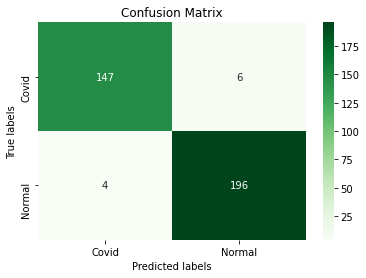

In [46]:
# Confusion Matrix for training data

cm=confusion_matrix(train_y, y_pred_train,labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='g',cmap='Greens')
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['Covid', 'Normal'])
ax.yaxis.set_ticklabels(['Covid','Normal'])

# cm=confusion_matrix(y_target=train_y,y_predicted=y_pred_train)
# fig,ax=plot_confusion_matrix(conf_mat=cm,cmap='Dark2',colorbar=True)
# labels=['normal','covid']
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)

# plt.title('Confusion Matrix')

# plt.show()


[Text(0, 0.5, 'Covid Positive'), Text(0, 1.5, 'Covid Negative')]

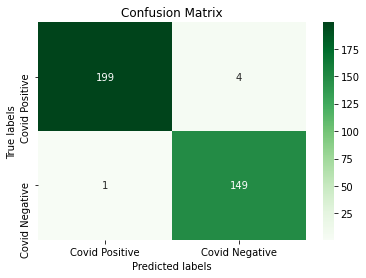

In [47]:
# Confusion Matrix for testing data

cm=confusion_matrix(test_y, y_pred_test,labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='g',cmap='Greens')
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['Covid Positive', 'Covid Negative'])
ax.yaxis.set_ticklabels(['Covid Positive','Covid Negative'])
# cm=confusion_matrix(y_target=test_y,y_predicted=y_pred_test)
# fig,ax=plot_confusion_matrix(conf_mat=cm,cmap='Dark2',colorbar=True)
# labels=['normal','covid']
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)

# plt.title('Confusion Matrix')
# plt.show()

In [48]:
y_pred_test=pd.Series(y_pred_test)
y_pred_test.value_counts()

1    200
0    153
dtype: int64

In [49]:
# Training Classification Report
print(classification_report(train_y,y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       200
           1       0.97      0.96      0.97       153

    accuracy                           0.97       353
   macro avg       0.97      0.97      0.97       353
weighted avg       0.97      0.97      0.97       353



In [50]:
# Testing Classification Report
print(classification_report(test_y,y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       150
           1       0.99      0.98      0.99       203

    accuracy                           0.99       353
   macro avg       0.98      0.99      0.99       353
weighted avg       0.99      0.99      0.99       353



In [51]:
# Checking the Cross Validation Score on Train Data
scores_train = cross_val_score(classifier,train_x, train_y, cv=10,scoring='accuracy')

In [52]:
# Checking the Cross Validation Score on Test Data
scores_test=cross_val_score(classifier,test_x,test_y,cv=10,scoring='accuracy')

In [53]:
print('Mean Cross Validation Train Score:{}'.format(np.mean(scores_train)))
print('Mean Cross Validation Test Score:{}'.format(np.mean(scores_test)))

Mean Cross Validation Train Score:0.9688095238095238
Mean Cross Validation Test Score:0.9857936507936508
